In [2]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/functions"))

In [3]:
from load_poses import get_poses_from_file
dataset_path = "/workspace/data/pose-prediction-odometry/tmp-testing/"
RO_se3s,RO_timestamps = get_poses_from_file(dataset_path)

Loading poses from monolithic file...
reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/tmp-testing/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 8421 poses.


In [4]:
# Crop poses - there was a dud pose at 6342, this is a quick fix for now
max_poses = 6000
RO_se3s = RO_se3s[:max_poses]
RO_timestamps = RO_timestamps[:max_poses]

train_test_ratio = 0.9
split_idx = int(len(RO_timestamps)*train_test_ratio)
train_RO_se3s = RO_se3s[:split_idx]
train_RO_timestamps = RO_timestamps[:split_idx]
test_RO_se3s = RO_se3s[split_idx:]
test_RO_timestamps = RO_timestamps[split_idx:]
print("Train set size:",len(train_RO_timestamps))
print("Test set size:",len(test_RO_timestamps))

Train set size: 5400
Test set size: 600


In [5]:
t_x_data = np.zeros(len(train_RO_timestamps))
t_y_data = np.zeros(len(train_RO_timestamps))
t_theta_data = np.zeros(len(train_RO_timestamps))

for i in range(len(train_RO_timestamps)):
    t_x_data[i] = train_RO_se3s[i][0,3]
    t_y_data[i] = train_RO_se3s[i][1,3]
    t_theta_data[i] = np.arccos(train_RO_se3s[i][0,0])
    
test_t_x_data = np.zeros(len(test_RO_timestamps))

for i in range(len(test_RO_timestamps)):
    test_t_x_data[i] = test_RO_se3s[i][0,3]

In [6]:
dim1_data = t_x_data
dim1_data_scaled = (dim1_data - dim1_data.mean())/dim1_data.std()

In [7]:
def sliding_window_delta(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length] - data[i+seq_length-1]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

my_arr = np.array([1,2,3,7,8,9,1,2,3])
x,y = sliding_window_delta(my_arr,3)
print(x)
print(y)

[[1 2 3]
 [2 3 7]
 [3 7 8]
 [7 8 9]
 [8 9 1]
 [9 1 2]]
[ 4  1  1 -8  1  1]


In [8]:
def sliding_windows(data, seq_length, output_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-(1+output_length)):
        _x = data[i:(i+seq_length)]
        _y = data[(i+seq_length):(i+seq_length+output_length)]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

training_data = dim1_data_scaled.reshape(-1,1)

seq_length = 10
single_output_length = 1
# x, y = sliding_windows(training_data, seq_length, single_output_length)
x, y = sliding_window_delta(training_data, seq_length)

x = np.squeeze(x)

train_test_ratio = 0.85
train_size = int(len(y) * train_test_ratio)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print("dataX:",dataX.shape)
print("trainX:",trainX.shape)
print("testX:",testX.shape)
print("dataY:",dataY.shape)
print("trainY:",trainY.shape)
print("testY:",testY.shape)

dataX: torch.Size([5390, 10])
trainX: torch.Size([4581, 10])
testX: torch.Size([809, 10])
dataY: torch.Size([5390, 1])
trainY: torch.Size([4581, 1])
testY: torch.Size([809, 1])


In [9]:
import torch.nn as nn
#our class must extend nn.Module
class BiggerNetwork(nn.Module):
    def __init__(self):
        super(BiggerNetwork,self).__init__()
        #Our network consists of 3 layers. 1 input, 1 hidden and 1 output layer
        #This applies Linear transformation to input data. 
        self.fc1 = nn.Linear(input_size,hidden_size)
        
        #This applies linear transformation to produce output data
        self.fc2 = nn.Linear(hidden_size,output_size)
        
    #This must be implemented
    def forward(self,x):
        #Output of the first layer
        x = self.fc1(x)
        #Activation function is Relu. Feel free to experiment with this
        x = torch.relu(x) # F.tanh(x)
        #This produces output
        x = self.fc2(x)
        return x    
    
class SimpleNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(input_size,output_size)

    def forward(self, xb):
        return self.lin(xb)

In [10]:
input_size = 10
output_size = 1
hidden_size = 1
model = SimpleNetwork()
print(model(trainX).shape)
print(trainY.size())

torch.Size([4581, 1])
torch.Size([4581, 1])


In [88]:
torch.manual_seed(0)

num_epochs = 1001
learning_rate = 0.01
input_size = 10
output_size = 1
hidden_size = 10
model = BiggerNetwork()

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model(trainX).size())
print(trainY.size())

# Train the model
for epoch in range(num_epochs):
    outputs = model(trainX) #.reshape(-1,single_output_length)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 50 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

torch.Size([4581, 1])
torch.Size([4581, 1])
Epoch: 0, loss: 0.09601
Epoch: 50, loss: 0.00697
Epoch: 100, loss: 0.00663
Epoch: 150, loss: 0.00615
Epoch: 200, loss: 0.00543
Epoch: 250, loss: 0.00527
Epoch: 300, loss: 0.00521
Epoch: 350, loss: 0.00515
Epoch: 400, loss: 0.00511
Epoch: 450, loss: 0.00509
Epoch: 500, loss: 0.00507
Epoch: 550, loss: 0.00506
Epoch: 600, loss: 0.00505
Epoch: 650, loss: 0.00505
Epoch: 700, loss: 0.00504
Epoch: 750, loss: 0.00504
Epoch: 800, loss: 0.00503
Epoch: 850, loss: 0.00503
Epoch: 900, loss: 0.00503
Epoch: 950, loss: 0.00504
Epoch: 1000, loss: 0.00502


In [89]:
def appender(input_seq,new_val):
    """
    Append value to input sequence (treat as arrays)
    """
    input_seq = np.delete(input_seq,0)
    updated_input_seq = np.append(input_seq,new_val)
    return updated_input_seq
my_arr = np.array([0,2,4,6])
print(my_arr)
my_new_arr = appender(my_arr,8)
print(my_new_arr)

[0 2 4 6]
[2 4 6 8]


In [90]:
tmp=(dataX.data.numpy()[:,-1])*dim1_data.std()+dim1_data.mean()
print("tmp1:",tmp)
# plt.plot(tmp);

tmp=(dataX.data.numpy()[:,-1]+dataY.data.numpy()[:,0])*dim1_data.std()+dim1_data.mean()
print("tmp2:",tmp)
# plt.plot(tmp);

print("dataY",dataY.data.numpy()[:,0])

tmp1: [ 0.00017357 -0.00136673  0.00039017 ... -0.00408697 -0.00159204
 -0.0088402 ]
tmp2: [-0.00136673  0.00039017 -0.00275433 ... -0.00159204 -0.00884008
  0.00023794]
dataY [-0.00183154  0.00208916 -0.00373913 ...  0.00296666 -0.00861864
  0.01079474]


data size and type: torch.Size([5390, 10]) <class 'torch.Tensor'>


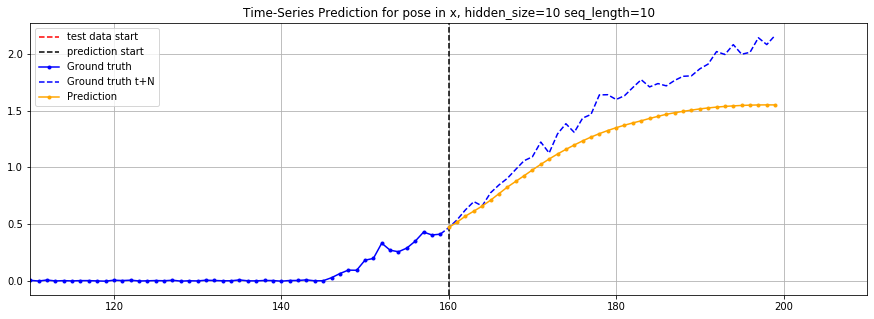

In [91]:
print("data size and type:",dataX.size(),type(dataX))

prediction_start_index = 160 #int(len(dataY)*train_test_ratio) + 10 #160
horizon = 40

model.eval()

input_seq = dataX[prediction_start_index]
future_val = model(dataX[prediction_start_index]).data.numpy()[0] + dataX[prediction_start_index][-1].data.numpy()

output_collection = np.empty(0)
output_collection = np.append(output_collection,future_val)

for i in range(horizon-1):
    updated_input_seq = appender(input_seq,future_val)
#     updated_input_seq = updated_input_seq[np.newaxis,...,np.newaxis]
    updated_input_seq = Variable(torch.tensor(updated_input_seq))
    next_prediction = model(updated_input_seq)
    
    # Update states
    input_seq = updated_input_seq
    future_val = next_prediction.data.numpy()+updated_input_seq[-1].data.numpy()
    output_collection = np.append(output_collection,future_val)
    
predictions = output_collection

# Scale outputs up again after the inputs had been scaled down - using training data ONLY (dim1_data)
data_predict_rescaled = predictions*dim1_data.std()+dim1_data.mean()
gt_vals_rescaled = (dataX.data.numpy()[:,-1]+dataY.data.numpy()[:,0])*dim1_data.std()+dim1_data.mean()

x_axis_ticks_horizon = np.linspace(prediction_start_index,prediction_start_index+horizon-1,horizon)
x_axis_ticks_tm1 = np.linspace(prediction_start_index-1,prediction_start_index+horizon-1,horizon+1)

plt.figure(figsize=(15,5))
plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
plt.axvline(x=prediction_start_index, c='k', linestyle='--',label="prediction start")
view_size = horizon+10
x_centre = prediction_start_index #len(dataY)*train_test_ratio
plt.xlim(x_centre-view_size,x_centre+view_size)
plt.plot(gt_vals_rescaled[:prediction_start_index],'b.-',label="Ground truth")
plt.plot(x_axis_ticks_tm1,gt_vals_rescaled[prediction_start_index-1:prediction_start_index+horizon],'b--',label="Ground truth t+N")
plt.plot(x_axis_ticks_horizon,data_predict_rescaled,'.-',color="orange",label="Prediction")

title_string = 'Time-Series Prediction for pose in x, '+'hidden_size='+str(hidden_size) \
             +' seq_length='+str(seq_length)
plt.title(title_string)
plt.grid()
plt.legend()

In [92]:
def get_error_metrics(gt_predictions,model_predictions):
    short_horizon = 5
    med_horizon = 20
    all_diffs = gt_predictions - model_predictions
    short_diffs = all_diffs[0:short_horizon]
    med_diffs = all_diffs[short_horizon:med_horizon]
    long_diffs = all_diffs[med_horizon:]
    short_rmse = np.sqrt(np.sum(np.square(short_diffs))/len(short_diffs))
    med_rmse = np.sqrt(np.sum(np.square(med_diffs))/len(med_diffs))
    long_rmse = np.sqrt(np.sum(np.square(long_diffs))/len(long_diffs))
    return(short_rmse, med_rmse, long_rmse)

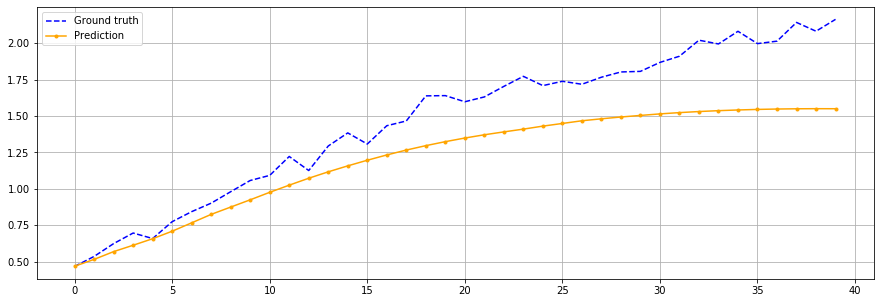

In [93]:
gt_predictions = gt_vals_rescaled[prediction_start_index:prediction_start_index+horizon]
model_predictions = data_predict_rescaled

plt.figure(figsize=(15,5))
plt.plot(gt_predictions,'b--',label="Ground truth")
plt.plot(model_predictions,'.-',color="orange",label="Prediction")
plt.grid()
plt.legend()

In [95]:
import datetime
from time import strftime
print(datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))

save_plots = True
prediction_start_index = 140 #int(len(dataY)*train_test_ratio) - 50
horizon = 40 -1 # -1 because we do first step outside the loop
num_frames_to_render = 300
all_short_rmse = []
all_med_rmse = []
all_long_rmse = []

experiment_dir = '/workspace/data/pose-prediction-odometry/'+datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
if save_plots:
#     os.mkdir(experiment_dir)
    for frame in range(prediction_start_index,prediction_start_index+num_frames_to_render):
        prediction_start_index = frame
        model.eval()
        input_seq = dataX[prediction_start_index]
        future_val = model(dataX[prediction_start_index]).data.numpy()[0] + dataX[prediction_start_index][-1].data.numpy()

        output_collection = np.empty(0)
        output_collection = np.append(output_collection,future_val)

        for i in range(horizon-1):
            updated_input_seq = appender(input_seq,future_val)
#             updated_input_seq = updated_input_seq[np.newaxis,...,np.newaxis]
            updated_input_seq = Variable(torch.tensor(updated_input_seq))
            next_prediction = model(updated_input_seq)

            # Update states
            input_seq = updated_input_seq
            future_val = next_prediction.data.numpy()+updated_input_seq[-1].data.numpy()
            output_collection = np.append(output_collection,future_val)

        predictions = output_collection

        # Scale outputs up again after the inputs had been scaled down - using training data ONLY (dim1_data)
        data_predict_rescaled = predictions*dim1_data.std()+dim1_data.mean()
        gt_vals_rescaled = (dataX.data.numpy()[:,-1]+dataY.data.numpy()[:,0])*dim1_data.std()+dim1_data.mean()

        # Error metrics
        gt_predictions = gt_vals_rescaled[prediction_start_index:prediction_start_index+horizon]
        model_predictions = data_predict_rescaled
        short_rmse, med_rmse, long_rmse = get_error_metrics(gt_predictions,model_predictions)
        all_short_rmse.append(short_rmse)
        all_med_rmse.append(med_rmse)
        all_long_rmse.append(long_rmse)
        
#         x_axis_ticks_horizon = np.linspace(prediction_start_index,prediction_start_index+horizon-1,horizon)
#         x_axis_ticks_tm1 = np.linspace(prediction_start_index-1,prediction_start_index+horizon-1,horizon+1)

#         fig = plt.figure(figsize=(15,5))
#         plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
#         plt.axvline(x=prediction_start_index, c='k', linestyle='--',label="prediction start")
#         view_size = horizon+10
#         x_centre = prediction_start_index #len(dataY)*train_test_ratio
#         plt.xlim(x_centre-view_size,x_centre+view_size)
#         plt.plot(gt_vals_rescaled[:prediction_start_index],'b.-',label="Ground truth")
#         plt.plot(x_axis_ticks_tm1,gt_vals_rescaled[prediction_start_index-1:prediction_start_index+horizon],'b--',label="Ground truth t+N")
#         plt.plot(x_axis_ticks_horizon,data_predict_rescaled,'.-',color="orange",label="Prediction")

#         title_string = 'Time-Series Prediction for pose in x, fc network, '+'hidden_size='+str(hidden_size) \
#                      +' seq_length='+str(seq_length)
#         plt.title(title_string)
#         plt.grid()
#         plt.legend()
#         plt.savefig("%s%s%i%s%i%s" % (experiment_dir,'/hiddensize-',hidden_size,'-frame-',frame,'.png'), \
#                 bbox_inches='tight')
#         plt.close(fig)
print("Mean short RMSE:",np.array(all_short_rmse).mean())
print("Mean med RMSE:",np.array(all_med_rmse).mean())
print("Mean long RMSE:",np.array(all_long_rmse).mean())


08-06-2020-16-06-37
Mean short RMSE: 0.08035464200080117
Mean med RMSE: 0.2306440474753632
Mean long RMSE: 0.5725253383259592
